In [1]:
# Objective: Getting people per admin area per landslide risk zone

# Input: admin0, admin1, region, landslide_raster (with x number of risk categories)
# Output: admin0, admin1 and region with one column per landslide_raster category containing number of people

# Steps:
# Load population data and landslide data
# Reproject so pixel size matches
# Create a mask from land slide data
# Use mask on population dataset
# Apply zonal stats across masked population dataset

In [2]:
import os
import geopandas as gpd
import pandas as pd
from sqlalchemy import create_engine
import psycopg2 # required for exporting to postgis
import rioxarray as rxr
from rasterio.crs import CRS
from sqlalchemy import create_engine
import rasterstats
from shapely.ops import transform
from datetime import datetime
import numpy as np

from rasterio.enums import Resampling

import xarray
import matplotlib.pyplot as plt

In [3]:
os.chdir('D:\iMMAP\proj\ASDC\data\Landslide\process_v05')

In [4]:
password = ''
db_connection_url = "postgresql://postgres:{}@localhost:5432/HSDC".format(password)
con = create_engine(db_connection_url)

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Define projection
#repro_crs = '+proj=cea'

### Select input data

In [7]:
adm = gpd.GeoDataFrame.from_postgis('SELECT * from afg_admbnda_adm1_testclip2', con) #.to_crs(repro_crs)
landslide = xarray.open_dataarray(r'D:\iMMAP\proj\ASDC\data\Landslide\afg_ls_30m_wb_s3_repro_clip_clip.tif').squeeze() # D:\iMMAP\proj\ASDC\data\afg_ls_30m_wb_s3_compressed.tif
pop = xarray.open_dataarray(r'D:\iMMAP\proj\ASDC\data\Landslide\worldpop_clip.tif').squeeze() # D:\iMMAP\data\Afghanistan\HSDC-Official\afg_worldpop_2020_UNadj_unconstrained.tif
build = gpd.GeoDataFrame.from_postgis('SELECT * from afg_buildings_microsoft_centroids_testclip1_tiny', con) #.to_crs(repro_crs)

### Reproject Landslide to match Pop

In [8]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"sum: {raster.sum().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [9]:
print("Original Raster:\n----------------\n")
print_raster(landslide)
print("Raster to Match:\n----------------\n")
print_raster(pop)

Original Raster:
----------------

shape: (8124, 11755)
resolution: (0.000296968550659294, -0.00029697948621368786)
bounds: (68.189874794, 33.008563730000006, 71.680740107, 35.421225076)
sum: 144120272.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (2895, 4189)
resolution: (0.0008333333301503922, -0.0008333333302245241)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 13708900.0
CRS: EPSG:4326



In [10]:
# Reproject to match target raster
landslide_repro = landslide.rio.reproject_match(pop)

In [11]:
print("Reprojected Raster:\n-------------------\n")
print_raster(landslide_repro)
print("Raster to Match:\n----------------\n")
print_raster(pop)

Reprojected Raster:
-------------------

shape: (2895, 4189)
resolution: (0.0008333333301503925, -0.000833333330224523)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 18301380.0
CRS: EPSG:4326

Raster to Match:
----------------

shape: (2895, 4189)
resolution: (0.0008333333301503922, -0.0008333333302245241)
bounds: (68.189583075, 33.00875006900001, 71.680416395, 35.42125006)
sum: 13708900.0
CRS: EPSG:4326



### Save reprojected landslide to file

In [12]:
# Save reprojected landslide data to file
landslide_repro.rio.to_raster("landslide_repro.tif")

### Create masked population rasters

In [13]:
# Loop through risk cats and create one dataset per cat

risk_category_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for risk_category in risk_category_list:
    pop_masked = pop.where(landslide_repro == risk_category, other=0)
    pop_masked.rio.to_raster('pop_masked_ls_risk_cat_{}.tif'.format(risk_category))


### Apply zonal stats on masked population rasters

In [14]:
# Defining zonal stats function

def ZonalStats(shape_gdf, raster, stats, nodata_value):

    zonalSt = rasterstats.zonal_stats(shape_gdf, raster, stats = stats, nodata=nodata_value)
    
    df = pd.DataFrame(zonalSt)
    
    df_concat = pd.concat([df, shape_gdf], axis=1)
    
    final_gdf = gpd.GeoDataFrame(df_concat, geometry=df_concat.geom) #wkb_geometry
    
    final_gdf_ordered = final_gdf[[c for c in final_gdf if c not in [stats]] + [stats]]
    
    #flood = final_gdf_ordered.rename(columns={"sum": "pop_sum"}) #, inplace=True)
    
    flood = final_gdf_ordered.drop(columns=['geometry'])
    
    flood = flood.set_geometry('geom')
    
    return flood

In [15]:
# Apply zonal stats to each raster
adm_stats = adm
risk_category_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for category in risk_category_list:
    raster = 'pop_masked_ls_risk_cat_{}.tif'.format(category)
    print(raster)
    
    adm_stats = ZonalStats(adm_stats, raster, 'sum', 'NaN') #change column name
 
    adm_stats = adm_stats.rename(columns={'sum': 'pop_{}'.format(category)})
    
    col = 'pop_{}'.format(category)
    
    adm_stats[col] = adm_stats[col].round(decimals=2)

pop_masked_ls_risk_cat_0.tif
pop_masked_ls_risk_cat_1.tif
pop_masked_ls_risk_cat_2.tif
pop_masked_ls_risk_cat_3.tif
pop_masked_ls_risk_cat_4.tif
pop_masked_ls_risk_cat_5.tif
pop_masked_ls_risk_cat_6.tif
pop_masked_ls_risk_cat_7.tif
pop_masked_ls_risk_cat_8.tif


In [16]:
# Create column with pop sum
sum_list = [
    'pop_0',
    'pop_1',
    'pop_2',
    'pop_3',
    'pop_4',
    'pop_5',
    'pop_6',
    'pop_7',
    'pop_8'
]

adm_stats['pop_sum'] = adm_stats[sum_list].sum(axis=1)

In [17]:
# Group to match desired categories
#0=Null; 1-3=Low; 4-5=Moderate; 6=High; 7-9=Very High
adm_stats['pop_ls_0'] = adm_stats['pop_0']
adm_stats['pop_ls_1'] = adm_stats[['pop_1', 'pop_2', 'pop_3']].sum(axis=1)
adm_stats['pop_ls_2'] = adm_stats[['pop_4', 'pop_6']].sum(axis=1)
adm_stats['pop_ls_3'] = adm_stats['pop_6']
adm_stats['pop_ls_4'] = adm_stats[['pop_7', 'pop_8']].sum(axis=1)

In [18]:
adm_stats

,id,geom,shape_leng,shape_area,adm1_en,adm1_da,adm1_pcode,adm1_ref,adm1alt1en,adm1alt2en,adm1alt1da,adm1alt2da,adm0_en,adm0_da,adm0_pcode,date,validon,validto,reg_en,reg_da,reg_pcode,pop_0,pop_1,pop_2,pop_3,pop_4,pop_5,pop_6,pop_7,pop_8,pop_sum,pop_ls_0,pop_ls_1,pop_ls_2,pop_ls_3,pop_ls_4
0,5,"MULTIPOLYGON (((69.81884 34.80029, 69.81822 34...",2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,12608.31,3.85,0.75,17087.82,53563.43,70405.11,53262.57,33618.92,6061.66,246612.42,12608.31,17092.42,106826.00,53262.57,39680.58
1,16,"MULTIPOLYGON (((69.48780 34.16098, 69.48661 34...",4.380275,0.460366,Kabul,کابل,AF01,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,40407.58,31.11,6.64,17890.69,207398.31,281972.59,125181.20,40564.99,8192.90,721646.01,40407.58,17928.44,332579.51,125181.20,48757.89
2,19,"MULTIPOLYGON (((69.97800 33.62184, 69.97799 33...",4.938876,0.531138,Paktya,پکتیا,AF13,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,427862.97,0.00,3606.62,17061.08,20660.60,152860.41,155763.22,33744.86,24767.63,836327.39,427862.97,20667.70,176423.82,155763.22,58512.49
3,24,"MULTIPOLYGON (((70.50041 34.51768, 70.49845 34...",3.327006,0.384020,Laghman,لغمان,AF07,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,412014.94,0.00,29.10,50075.89,70816.09,73976.43,73985.55,15312.47,5946.08,702156.55,412014.94,50104.99,144801.64,73985.55,21258.55
4,26,"MULTIPOLYGON (((68.78219 33.61425, 68.78328 33...",4.247632,0.428761,Logar,لوگر,AF05,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,12443.92,0.00,9.03,24286.61,25887.87,23960.29,41377.83,3050.54,4939.57,135955.66,12443.92,24295.64,67265.70,41377.83,7990.11
5,27,"MULTIPOLYGON (((71.03569 34.56707, 71.03462 34...",4.027321,0.416132,Kunar,کنر ها,AF15,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,151365.52,0.00,5362.19,89968.89,51607.90,158772.84,84989.77,50109.02,24814.52,616990.65,151365.52,95331.08,136597.67,84989.77,74923.54
6,30,"MULTIPOLYGON (((68.91945 34.80273, 68.91932 34...",5.324653,0.550813,Parwan,پروان,AF03,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,58448.36,0.00,139.44,18100.42,59824.84,82526.85,127619.50,21139.18,36962.69,404761.28,58448.36,18239.86,187444.34,127619.50,58101.87
7,31,"MULTIPOLYGON (((69.35163 33.05242, 69.35296 33...",3.993206,0.398140,Khost,خوست,AF14,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,709561.81,0.00,5793.16,37233.02,79815.36,75434.71,95877.33,19071.02,12609.52,1035395.93,709561.81,43026.18,175692.69,95877.33,31680.54
8,33,"MULTIPOLYGON (((70.90162 33.98614, 70.90083 33...",5.325266,0.721955,Nangarhar,ننگرهار,AF06,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,1784822.62,0.00,24.66,76121.83,93183.82,143801.33,136968.39,20543.10,11103.59,2266569.34,1784822.62,76146.49,230152.21,136968.39,31646.69


### Extract buildings

In [19]:

# prepare clipped data input for test run

# Input: building centroids, landslide dataset
# Desired output: number of buildings per land slide risk catagory per admin polygon

# Approach:
# Extract pixel value to building centroids
# Loop over landslide risk category
# For each risk category
    # filter the points so the dataset only includes points from that category
    # perform spatial join on remaining points

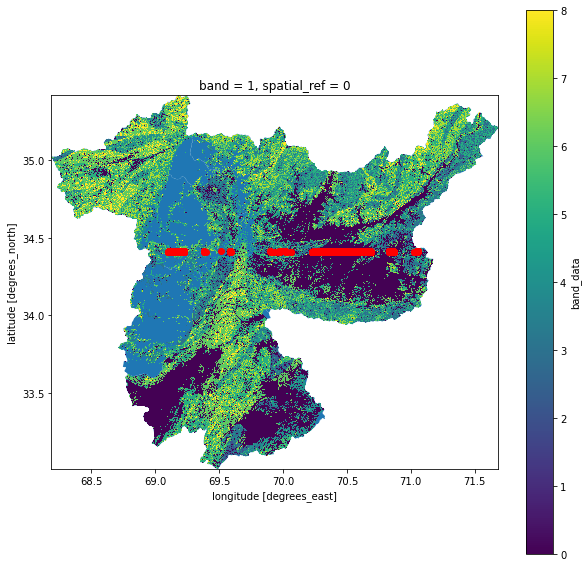

In [20]:
### Explored data

fig, ax = plt.subplots(figsize=(10, 10))

adm.plot(ax=ax)
landslide_repro.plot(ax=ax)
build.plot(ax=ax, color='red')

plt.show()

In [21]:
print('adm crs', adm.crs)
print('build crs', build.crs)
print('landslide_repro crs', landslide_repro.rio.crs)

adm crs epsg:4326
build crs epsg:4326
landslide_repro crs EPSG:4326


In [22]:
# Applying point stats and concatenating output to input geometry
# Output: buildings with associated landslide risk column

def point_stats(shape_gdf, raster_file_path):

    pointSt = rasterstats.point_query(shape_gdf, raster_file_path, interpolate='nearest')

    df = pd.DataFrame(pointSt)
    
    df_concat = pd.concat([df, shape_gdf], axis=1)
    
    gdf = gpd.GeoDataFrame(df_concat, geometry=df_concat.geom) #wkb_geometry
    
    gdf_ordered = gdf[[c for c in gdf if c not in [0]] + [0]] # 0 refers to column name
    
    gdf_clean = gdf_ordered.drop(columns=['geometry']).set_geometry('geom').rename(columns={0:'risk'})
        
    return gdf_clean

In [23]:
build_risk = point_stats(build, 'landslide_repro.tif')

In [24]:
# Joining points to polygon
# Group points by pcode and get count (=number of points within each pcode)
# Merge point could back to original polygon dataset

# Group by parameter = pcode

def buildings(polygons, build_centroids, group_by_parameter, build_count_column):
    
    # Join building centroids to flood polygons
    #print('    Joining buildings to flood polygons   Start: {}'.format(datetime.now().strftime("%H:%M:%S")))
    joined_df = gpd.sjoin(
        build_centroids,
        polygons,
        how='inner',
        predicate='intersects'
    )
    #print('    Joining buildings to flood polygons   End:   {}'.format(datetime.now().strftime("%H:%M:%S")))
    
    # Count number of buildings within admin polygons
    #print('    Counting number of buildings          Start: {}'.format(datetime.now().strftime("%H:%M:%S")))
    build_count = joined_df.groupby(
        [group_by_parameter],
        as_index=False,
    )['geom'].count() # vuid is arbitrary, we just count the row
    #print('    Counting number of buildings          End:   {}'.format(datetime.now().strftime("%H:%M:%S")))
    
    # Change column name to build_count
    build_count.rename(columns = {'geom': build_count_column}, inplace = True)

    # Merge build count back on to admin dataset
    polygons = polygons.merge(
        build_count, 
        on=group_by_parameter, 
        how='left')
    
    return polygons

In [25]:
# loop over risk categories

pcode = 'adm1_pcode'

risk_category_list = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for category in risk_category_list:
    
    build_filtered = build_risk.query('risk == {}'.format(category))
    
    build_count_column = 'build_{}'.format(category)
    
    adm_stats = buildings(adm_stats, build_filtered, pcode, build_count_column)

In [26]:
adm_stats

,id,geom,shape_leng,shape_area,adm1_en,adm1_da,adm1_pcode,adm1_ref,adm1alt1en,adm1alt2en,adm1alt1da,adm1alt2da,adm0_en,adm0_da,adm0_pcode,date,validon,validto,reg_en,reg_da,reg_pcode,pop_0,pop_1,pop_2,pop_3,pop_4,pop_5,pop_6,pop_7,pop_8,pop_sum,pop_ls_0,pop_ls_1,pop_ls_2,pop_ls_3,pop_ls_4,build_0,build_1,build_2,build_3,build_4,build_5,build_6,build_7,build_8
0,5,"MULTIPOLYGON (((69.81884 34.80029, 69.81822 34...",2.393424,0.185458,Kapisa,کاپیسا,AF02,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,12608.31,3.85,0.75,17087.82,53563.43,70405.11,53262.57,33618.92,6061.66,246612.42,12608.31,17092.42,106826.00,53262.57,39680.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16,"MULTIPOLYGON (((69.48780 34.16098, 69.48661 34...",4.380275,0.460366,Kabul,کابل,AF01,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,40407.58,31.11,6.64,17890.69,207398.31,281972.59,125181.20,40564.99,8192.90,721646.01,40407.58,17928.44,332579.51,125181.20,48757.89,13.0,NaN,NaN,54.0,2.0,71.0,30.0,NaN,NaN
2,19,"MULTIPOLYGON (((69.97800 33.62184, 69.97799 33...",4.938876,0.531138,Paktya,پکتیا,AF13,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,427862.97,0.00,3606.62,17061.08,20660.60,152860.41,155763.22,33744.86,24767.63,836327.39,427862.97,20667.70,176423.82,155763.22,58512.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,24,"MULTIPOLYGON (((70.50041 34.51768, 70.49845 34...",3.327006,0.384020,Laghman,لغمان,AF07,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,412014.94,0.00,29.10,50075.89,70816.09,73976.43,73985.55,15312.47,5946.08,702156.55,412014.94,50104.99,144801.64,73985.55,21258.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,26,"MULTIPOLYGON (((68.78219 33.61425, 68.78328 33...",4.247632,0.428761,Logar,لوگر,AF05,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,12443.92,0.00,9.03,24286.61,25887.87,23960.29,41377.83,3050.54,4939.57,135955.66,12443.92,24295.64,67265.70,41377.83,7990.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,27,"MULTIPOLYGON (((71.03569 34.56707, 71.03462 34...",4.027321,0.416132,Kunar,کنر ها,AF15,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,151365.52,0.00,5362.19,89968.89,51607.90,158772.84,84989.77,50109.02,24814.52,616990.65,151365.52,95331.08,136597.67,84989.77,74923.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,30,"MULTIPOLYGON (((68.91945 34.80273, 68.91932 34...",5.324653,0.550813,Parwan,پروان,AF03,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Capital,مرکزی حوزه,CR,58448.36,0.00,139.44,18100.42,59824.84,82526.85,127619.50,21139.18,36962.69,404761.28,58448.36,18239.86,187444.34,127619.50,58101.87,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,31,"MULTIPOLYGON (((69.35163 33.05242, 69.35296 33...",3.993206,0.398140,Khost,خوست,AF14,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,South Eastern,جنوب ختیځه حوزه,SE,709561.81,0.00,5793.16,37233.02,79815.36,75434.71,95877.33,19071.02,12609.52,1035395.93,709561.81,43026.18,175692.69,95877.33,31680.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,33,"MULTIPOLYGON (((70.90162 33.98614, 70.90083 33...",5.325266,0.721955,Nangarhar,ننگرهار,AF06,None,None,None,None,None,Afghanistan,افغانستان,AF,2017-12-12,2021-11-17,None,Eastern,ختیځه حوزه,ER,1784822.62,0.00,24.66,76121.83,93183.82,143801.33,136968.39,20543.10,11103.59,2266569.34,1784822.62,76146.49,230152.21,136968.39,31646.69,15448.0,NaN,NaN,11.0,10.0,152.0,34.0,NaN,NaN


In [ ]:
# Convert building columns to categories 0-4